In [1]:
## Enviroment Setup
import os, sys
WORKING_DIR = '/home/peizhi/Documents/flame-head-tracker'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())

## Computing Device
device = 'cuda:0'
import torch
torch.cuda.set_device(device) # this will solve the problem that OpenGL not on the same device with torch tensors

sys.path.append(WORKING_DIR)
sys.path.append('./utils/flame_lib/')
sys.path.append('./utils/flame_fitting/')
sys.path.append('./utils/face_parsing/')
sys.path.append('./utils/decalib/')
sys.path.append('./utils/mesh_renderer')
sys.path.append('./utils/scene')

import matplotlib.pyplot as plt
import numpy as np

from tracker_base_multiview import Tracker


def plot(ret_dict):
    N = len(ret_dict['img']) # number of views
    for i in range(N):
        # plot some results
        plt.figure(figsize=(15,6))

        plt.subplot(1,6,1)
        plt.imshow(ret_dict['img'][i]); plt.title('img')

        plt.subplot(1,6,2)
        plt.imshow(ret_dict['img_aligned'][i]); plt.title('img_aligned')

        plt.subplot(1,6,3)
        plt.imshow(ret_dict['parsing'][i]); plt.title('parsing')

        plt.subplot(1,6,4)
        plt.imshow(ret_dict['parsing_aligned'][i]); plt.title('parsing_aligned')

        plt.subplot(1,6,5)
        plt.imshow(ret_dict['img_rendered'][i]); plt.title('img_rendered')

        plt.subplot(1,6,6)
        plt.imshow(ret_dict['mesh_rendered'][i]); plt.title('mesh_rendered')

        plt.show()
        

Current Working Directory:  /home/peizhi/Documents/flame-head-tracker
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

###########################
## Setup Flame Tracker    #     
###########################

tracker_cfg = {
    'mediapipe_face_landmarker_v2_path': './models/face_landmarker_v2_with_blendshapes.task',
    'flame_model_path': './models/FLAME2020/generic_model.pkl',
    'flame_lmk_embedding_path': './models/landmark_embedding.npy',
    'tex_space_path': './models/FLAME_albedo_from_BFM.npz',
    'face_parsing_model_path': './utils/face_parsing/79999_iter.pth',
    'uv_coord_mapping_file_path': './models/uv2vert_256.npy',
    'template_mesh_file_path': './models/head_template.obj',
    'result_img_size': 512,
    'device': device,
}

tracker = Tracker(tracker_cfg)



I0000 00:00:1733180730.173547  922136 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733180730.213541  922451 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A6000/PCIe/SSE2
W0000 00:00:1733180730.214176  922136 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1733180730.227412  922460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733180730.245016  922480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


creating the FLAME Decoder


/home/peizhi/Documents/flame-head-tracker/utils/flame_lib/FLAME.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_faces_idx', torch.tensor(lmk_embeddings['dynamic_lmk_faces_idx'], dtype=torch.long))
/home/peizhi/Documents/flame-head-tracker/utils/flame_lib/FLAME.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_bary_coords', torch.tensor(lmk_embeddings['dynamic_lmk_bary_coords'], dtype=self.dtype))
/home/peizhi/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: ./models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
/home/peizhi/mini

creating the FLAME Decoder
trained model found. load models/deca_model.tar
Flame Tracker ready.


/home/peizhi/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


### Landmark-based Fitting



/home/peizhi/miniconda3/envs/tracker/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


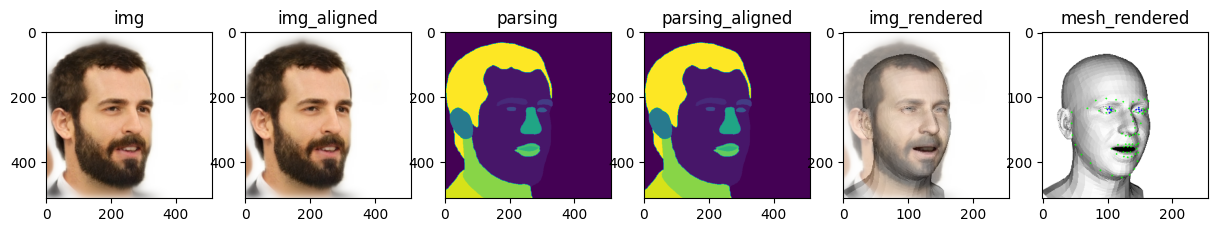

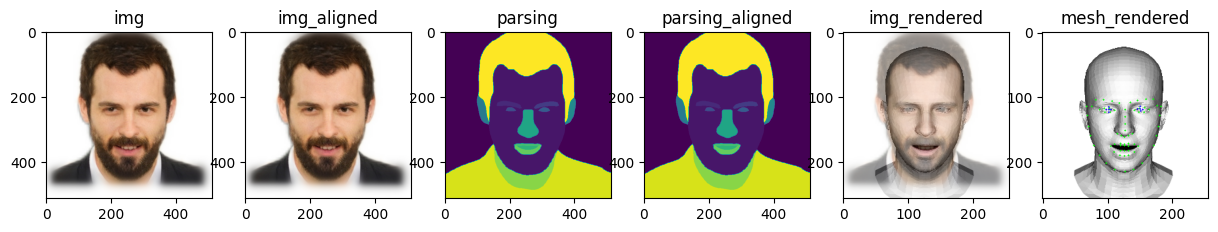

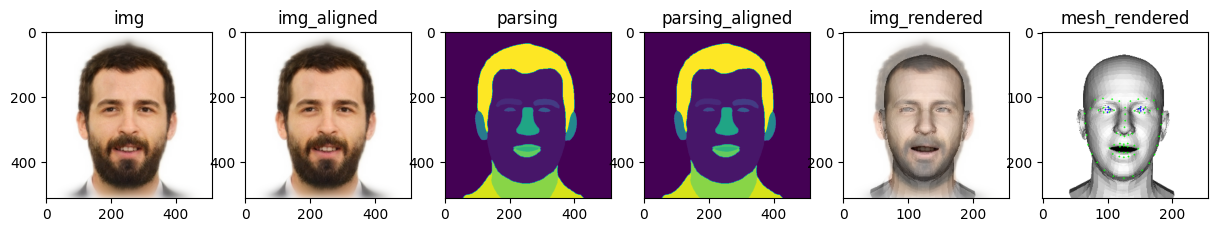

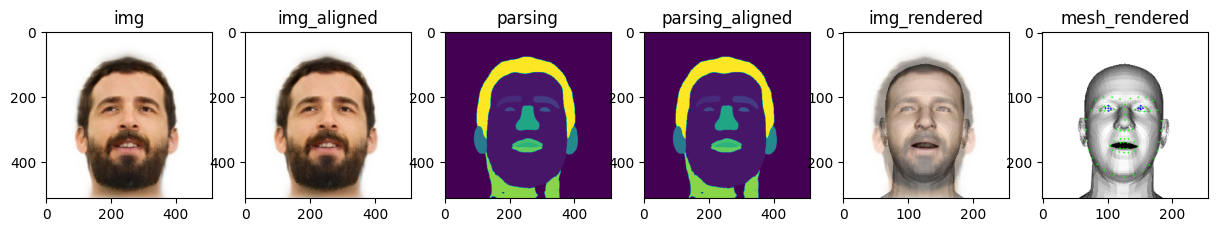

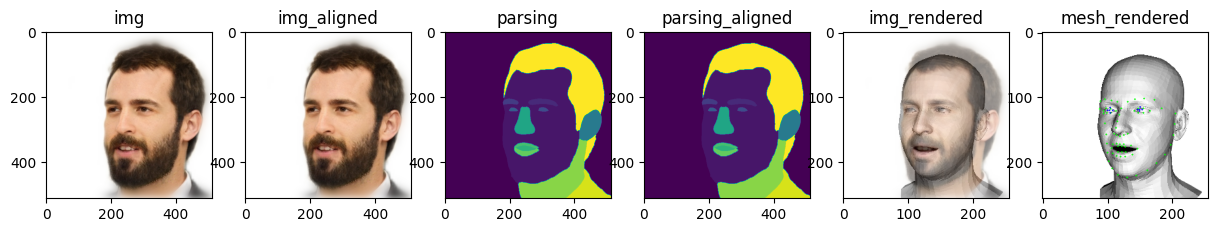

Key             	 Data Type 	 Shape
-----------------------------------------------------------
vertices        	 np.array 	 (5023, 3)
shape           	 np.array 	 (1, 100)
exp             	 np.array 	 (1, 50)
pose            	 np.array 	 (1, 6)
eye_pose        	 np.array 	 (1, 6)
tex             	 np.array 	 (1, 50)
light           	 np.array 	 (1, 9, 3)
cam             	 list     	 5*(6,)
img_rendered    	 list     	 5*(256, 256, 3)
mesh_rendered   	 list     	 5*(256, 256, 3)
img             	 list     	 5*(512, 512, 3)
img_aligned     	 list     	 5*(512, 512, 3)
parsing         	 list     	 5*(512, 512)
parsing_aligned 	 list     	 5*(512, 512)


In [4]:
"""
example multi-view images used here were generated using PanoHead
https://github.com/SizheAn/PanoHead
"""

img_paths = [
    './assets/multi-view-example/img_aligned_(-0.5_0.0).jpg',
    './assets/multi-view-example/img_aligned_(0.0_-0.5).jpg',
    './assets/multi-view-example/img_aligned_(0.0_0.0).jpg',
    './assets/multi-view-example/img_aligned_(0.0_0.5).jpg',
    './assets/multi-view-example/img_aligned_(0.5_0.0).jpg',
]

ret_dict = tracker.load_images_and_run(img_paths, realign=True, photometric_fitting=False)
plot(ret_dict)


# # check the shapes of returned results
print('Key             \t Data Type \t Shape')
print('-----------------------------------------------------------')
for key in ret_dict:
    key_str = f'{key}'.ljust(15) 
    if type(ret_dict[key]) is list:
        print(f'{key_str} \t list     \t {len(ret_dict[key])}*{ret_dict[key][0].shape}')
    else:
        print(f'{key_str} \t np.array \t {ret_dict[key].shape}')

